**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

In [1]:
# https://habr.com/ru/company/dca/blog/274027/
# http://neuro.compute.dtu.dk/wiki/Sentiment_analysis#Corpora
# http://help.sentiment140.com/for-students/
# http://study.mokoron.com

## Библиотеки

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
import gzip
import gc
import pickle
import matplotlib.pyplot as plt

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
neg = pd.read_csv('../data/text/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [6]:
pos = pd.read_csv('../data/text/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [7]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [8]:
%xdel neg
%xdel pos

In [9]:
data.sample(10)

,id,ttext,ttype
12226,409309919364775936,"@Garcon_Inconnu кстати, если ты не в курсе... На фото которое ты ретвитнул Эдди Мерфи.... ))))",1
62444,410303788369850368,"Мало кто заметил, @PolyakovaMusic Ольга Полякова заменила в Украине Верку Сердючку:)\nВсе новые песни идентичны Данилке",1
72353,418062395047940096,"@LevaHater заслуживаешь, конечно! Ты себя как всегда порицаешь :(",-1
103238,411110256828088320,5 6 хvнтэй жижигхээн байгууллага суугаад сайхан хоол идээд яриад суучих ресторан мэдэхvv? ойрхон караокетэй бол бvvр сайн :) #ЦомхонШинэЖил,1
17200,409368410556878848,"Кишки,кровь и все такое,а там говорят:""Не беспокойся. Это всего лишь ранка""\nНихуяшечки ранка на пол тела.\n:D",1
97543,411042888794259456,RT @sonyakazhan: @AlenaPolitik @SimoneCerbolini Вставаааай!!! Приплыли! ))),1
1366,408921522003144704,обещала мне ту одна сучка позвонить)только начала материть и звоноооок),1
290,408910070500839424,Рождественский дизайн стаканчиков от kuzina_nsk )\n#christmas @ Kuzina http://t.co/rBbXaUTLmU,1
44754,409978911184138240,"Если ты все ломешь, роняешь, проливаешь и падаешь, и тебе от этого весело-это нормально? Мне очень важен ответ на этот вопрос!)",1
76247,419089960537296896,"меня зовёт гулять человек,которого я ппц давно не видела! но я ж собиралась сегодня киношки дома смотреть :( #дилемма",-1


## очистка данных

In [10]:
data['ttext_clean'] = data['ttext'].apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )

In [11]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t  ]
  )

In [12]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ]
  )

In [13]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ]
  )

In [14]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ]
  )

In [15]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ]
  )

In [16]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ]
  )

In [17]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [18]:
data['ttext_clean'] = data['ttext_clean'].str.lower()
data['ttext_clean'] = data['ttext_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['ttext_clean'] = data['ttext_clean'].apply(lambda s: re.sub( r'_', ' ', s))
data['ttext_clean'] = data['ttext_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s)) 


In [19]:
data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )

In [20]:
# замена буквенно-цифровых кодов
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ]
)

In [21]:
# data[['ttext_clean']]
# data[['ttext']]

---

In [22]:
with gzip.open('../data/text/stop-nltk.txt.gz','rt',encoding='utf-8') as f: 
    stopwords = set([ w.strip() for w in  f.read().split() if w.strip() ] )
ppr(stopwords)

записей: 151


In [23]:
# удаление лишних слов
data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[w for w in t if w not in stopwords])

In [24]:
%xdel stopwords

In [25]:
# %%time 

# from Stemmer import Stemmer
# # pacman -S python-pystemmer
# # pip install pystemmer

# # стемминг, выделение основы слова
# data['ttext_clean'] = data['ttext_clean'].apply( lambda t:Stemmer('russian').stemWords(t) )

In [26]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[w for w in t if len(w)>2])

---

In [27]:
# data[ data['ttext_clean'].str.len()<1 ][['ttext_clean']]

In [28]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 826


In [29]:
data.sample(3)

,id,ttext,ttype,ttext_clean
24933,409552404267675648,"RT @bella_shmella: Девушка на улице рассказывает своему мол.человеку: ""Мы не нажрались. Мы типа посидели""))).",1,"[bella, shmella, девушка, улице, рассказывает, своему, мол, человеку, нажрались, типа, посидели, happysmile]"
215150,423415700943020032,"RT @redhot4ili: ""Росатом"" пригласили строить АЭС в Англии. Как же так, Запад должен был помочь, но не Кремлю же, а качать лодку...( http://…",-1,"[росатом, пригласили, строить, аэс, англии, запад, должен, помочь, кремлю, качать, лодку, url]"
69012,410407156127916032,Вот как понять этих пацанов уже и признается)и все вроде тип топ))ПАЦАНЫ НЕ МЕДЛИТЕ В ОТНОШ,1,"[понять, этих, пацанов, признается, вроде, тип, топ, happysmile, пацаны, медлите, отнош]"


## строим датасет

### дополняем и перестраиваем текст

In [30]:
# vocab = ['<PAD>','<START>','<UNK>'] + sorted(set([ w for t in data_train['ttext_clean'] for w in t if w ]))
# ppr(vocab)

In [31]:
data['ttext_clean'] = data['ttext_clean'] + ['<START>']

In [32]:
n_max = data['ttext_clean'].str.len().max()
n_max

31

In [33]:
pad = ['<PAD>']*n_max

In [34]:
data[['ttext_clean']].sample(3)

,ttext_clean
72219,"[xamka, digit, дааа, получается, друг, друга, знаем, надеюсь, тройка, которая, раньше, <START>]"
143439,"[просто, найти, эфир, проспойлерить, вылетел, sadsmile, sytycd, <START>]"
187764,"[вчера, лента, инсте, такая, новогодняя, digit, sadsmile, <START>]"


In [35]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t: pad[len(t):] + list(reversed(t)) 
  )

In [36]:
data[['ttext_clean']].sample(3)

,ttext_clean
9869,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <START>, получилось, хотьбы, happysmile, ..."
72953,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <START>, дождусь, большего, виду, иметь, буду, место, п..."
197422,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <START>, слов, мало, слишком, sads..."


In [37]:
%%time

from gensim.models.word2vec import Word2Vec

w2v_size = 256

w2v = Word2Vec( data['ttext_clean'].values, min_count=1, size=w2v_size, window=4, workers=4)

# with open('result/Word2Vec.pkl', 'wb') as f: pickle.dump(w2v, f)

CPU times: user 36 s, sys: 544 ms, total: 36.5 s
Wall time: 17.4 s


In [38]:
w2v_vocab = sorted([w for w in w2v.wv.vocab])
ppr(w2v_vocab)

записей: 239 404


In [39]:
data['ttext_code'] = data['ttext_clean'].apply(lambda t: [ w2v.wv.get_vector(w) for w in t ] )

### разделяем данные

In [40]:
batch_size=64

In [41]:
data_train = data.sample(batch_size*1000).reset_index(drop=True)
ppr(data_train)

записей: 64 000


In [42]:
data_test = data[ ~data['id'].isin( data_train['id'] ) ].reset_index(drop=True)
ppr(data_test)

записей: 162 826


In [43]:
data_val = data_train.sample(batch_size*300).reset_index(drop=True)
ppr(data_val)

записей: 19 200


In [44]:
data_train = data_train[ ~data_train['id'].isin( data_val['id'] ) ].reset_index(drop=True)
ppr(data_train)

записей: 44 800


---

In [45]:
X_train = np.stack([ np.vstack(s) for s in  data_train['ttext_code'] ])
X_train.shape

(44800, 31, 256)

In [46]:
X_val = np.stack([ np.vstack(s) for s in  data_val['ttext_code'] ])
X_val.shape

(19200, 31, 256)

In [47]:
X_test = np.stack([ np.vstack(s) for s in  data_test['ttext_code'] ])
X_test.shape

(162826, 31, 256)

In [48]:
from sklearn.preprocessing import OneHotEncoder

In [49]:
y_train = data_train['ttype'].values
y_train = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1,1) ).todense().astype(np.float32)
y_train.shape

(44800, 2)

In [50]:
y_val = data_val['ttype'].values
y_val = OneHotEncoder(categories='auto').fit_transform(y_val.reshape(-1,1) ).todense().astype(np.float32)
y_val.shape

(19200, 2)

In [51]:
y_test = data_test['ttype'].values
y_test = OneHotEncoder(categories='auto').fit_transform(y_test.reshape(-1,1) ).todense().astype(np.float32)
y_test.shape

(162826, 2)

---

In [52]:
np.save('X_train.npy',X_train)
np.save('y_train.npy',y_train)

np.save('X_val.npy',X_val)
np.save('y_val.npy',y_val)

np.save('X_test.npy',X_test)
np.save('y_test.npy',y_test)

with open('w2v.pkl', 'wb') as f: pickle.dump(w2v, f)

data_train.to_pickle('data_train.pkl')
data_train.to_pickle('data_val.pkl')
data_test.to_pickle('data_test.pkl')

In [53]:
%xdel data
%xdel data_train
%xdel data_val
%xdel data_test
%xdel w2v

In [54]:
gc.collect()

124

## строим нейросеть 

In [55]:
# import numpy as np

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [56]:
#batch_size=64

data_dim = X_train.shape[2]
time_steps = X_train.shape[1]
num_classes = y_train.shape[1]

In [59]:
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, data_dim),return_sequences=False, stateful=False))  
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [60]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [61]:
%%time

history = model.fit( X_train,y_train, batch_size=batch_size, epochs=10, validation_data=(X_val, y_val) )

Instructions for updating:
Use tf.cast instead.
Train on 44800 samples, validate on 19200 samples
Epoch 1/10
44800/44800 [==============================] - 84s 2ms/step - loss: 0.3458 - acc: 0.8158 - val_loss: 0.2344 - val_acc: 0.8685
Epoch 2/10
44800/44800 [==============================] - 73s 2ms/step - loss: 0.2495 - acc: 0.8660 - val_loss: 0.2250 - val_acc: 0.8801
Epoch 3/10
44800/44800 [==============================] - 73s 2ms/step - loss: 0.2238 - acc: 0.8799 - val_loss: 0.2142 - val_acc: 0.8885
Epoch 4/10
44800/44800 [==============================] - 72s 2ms/step - loss: 0.2120 - acc: 0.8893 - val_loss: 0.2242 - val_acc: 0.8817
Epoch 5/10
44800/44800 [==============================] - 71s 2ms/step - loss: 0.2035 - acc: 0.8960 - val_loss: 0.2027 - val_acc: 0.8981
Epoch 6/10
44800/44800 [==============================] - 72s 2ms/step - loss: 0.1973 - acc: 0.9006 - val_loss: 0.1992 - val_acc: 0.9017
Epoch 7/10
44800/44800 [==============================] - 73s 2ms/step - loss: 0

---

In [62]:
# save as JSON
with open('model.json', 'wt') as f: f.write( model.to_json() )
model.save_weights('model_weights.h5')

# from keras.models import model_from_json
# with open('model.json', 'rt') as f: model = model_from_json(f.read())
# model.load_weights('my_model_weights.h5')

---

In [63]:
%%time

results = model.evaluate(X_test,y_test)

print(results)

162826/162826 [==============================] - 138s 850us/step
[0.198192914025296, 0.9024050213096285]
CPU times: user 2min 27s, sys: 13 s, total: 2min 40s
Wall time: 2min 18s


---

In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

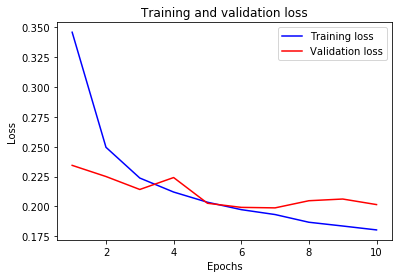

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

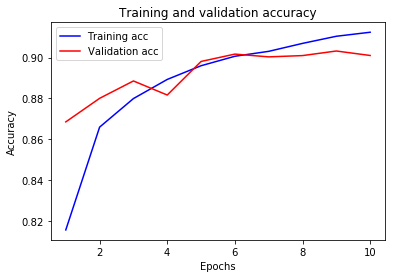

In [66]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

In [ ]:
# from keras.preprocessing import sequence
# from keras.utils import np_utils
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers.embeddings import Embedding
# from keras.layers.recurrent import LSTM

In [ ]:
# max_features = 100000
# maxlen = X.shape[0]
# # batch_size = 32

# model = Sequential()
# model.add(Embedding(max_features, 128, input_length=maxlen))
# # model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(64))
# # model.add(Dropout(0.5))
# model.add(Dense(2))
# model.add(Activation('sigmoid'))

In [ ]:
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               class_mode="binary")

In [ ]:
# model.fit(
#     X, y, 
#     batch_size=batch_size, 
#     nb_epoch=1 # , show_accuracy=True
# )

In [ ]:
# result = model.predict_proba(X)

---

In [ ]:
# import numpy as np

# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense

In [ ]:
# data_dim = 16
# timesteps = 8
# num_classes = 2

# num_ex = 1000

# x_train = np.random.random((num_ex, timesteps, data_dim))
# y_train = np.random.randint(1,3,num_ex)

# x_train.shape

# # [ пример, элемент посл., вектор ]

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# y_train = np.random.randint(1,3,num_ex)
# y_train = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1,1) ).todense()
# y_train.shape

In [ ]:
# # expected input data shape: (batch_size, timesteps, data_dim)
# model = Sequential()

# # returns a sequence of vectors of dimension 32
# model.add(LSTM(32,return_sequences=True,input_shape=(timesteps, data_dim)))  

# # returns a sequence of vectors of dimension 32
# model.add(LSTM(32,return_sequences=True))  

# model.add(LSTM(32))  # return a single vector of dimension 32

# model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# # expected input data shape: (batch_size, timesteps, data_dim)
# model = Sequential()

# # returns a sequence of vectors of dimension 32
# model.add(LSTM(32,input_shape=(timesteps, data_dim)))  

# model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

In [ ]:
# model.fit(x_train, y_train,
#           batch_size=64, epochs=115,
#           # validation_data=(x_val, y_val)
#          )